In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/reddit-sentiment-analysis/netflix.csv
/kaggle/input/reddit-sentiment-analysis/nvidia.csv
/kaggle/input/reddit-sentiment-analysis/tesla.csv
/kaggle/input/reddit-sentiment-analysis/gme.csv
/kaggle/input/reddit-sentiment-analysis/gme_wsb.csv


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
gme = pd.read_csv('/kaggle/input/reddit-sentiment-analysis/gme.csv')
netflix = pd.read_csv('/kaggle/input/reddit-sentiment-analysis/netflix.csv')
nvidia = pd.read_csv('/kaggle/input/reddit-sentiment-analysis/nvidia.csv')
tesla = pd.read_csv('/kaggle/input/reddit-sentiment-analysis/tesla.csv')

In [20]:
print('GME has' + str(gme.shape))
print('netflix has' + str(netflix.shape))
print('nvidia has' + str(nvidia.shape))
print('tesla has' + str(tesla.shape))

GME has(48960, 9)
netflix has(35999, 9)
nvidia has(36000, 9)
tesla has(36000, 9)


In [21]:
# GME
gme['Date'] = pd.to_datetime(gme['Date'])
gme.set_index('Date', inplace=True)
gme = gme.interpolate(method='linear')
first_non_nun_close_gme = gme['close'][gme['close'].first_valid_index()]
gme['close'] = gme['close'].fillna(value=first_non_nun_close_gme)
gme = gme.resample('60T').agg({'Sentiment_Score': 'sum', 'Updated_Sentiment_Score': 'sum', 'Fintech_Sentiment_Score': 'sum', 'close': 'mean'})

# netflix
netflix['Date'] = pd.to_datetime(netflix['Date'])
netflix.set_index('Date', inplace=True)
netflix = netflix.interpolate(method='linear')
first_non_nun_close_netflix = netflix['close'][netflix['close'].first_valid_index()]
netflix['close'] = netflix['close'].fillna(value=first_non_nun_close_netflix)
netflix = netflix.resample('60T').agg({'Sentiment_Score': 'sum', 'Updated_Sentiment_Score': 'sum', 'Fintech_Sentiment_Score': 'sum', 'close': 'mean'})

# nvidia
nvidia['Date'] = pd.to_datetime(nvidia['Date'])
nvidia.set_index('Date', inplace=True)
nvidia = nvidia.interpolate(method='linear')
first_non_nun_close_nvidia = nvidia['close'][nvidia['close'].first_valid_index()]
nvidia['close'] = nvidia['close'].fillna(value=first_non_nun_close_nvidia)
nvidia = nvidia.resample('60T').agg({'Sentiment_Score': 'sum', 'Updated_Sentiment_Score': 'sum', 'Fintech_Sentiment_Score': 'sum', 'close': 'mean'})

# tesla
tesla['Date'] = pd.to_datetime(tesla['Date'])
tesla.set_index('Date', inplace=True)
tesla = tesla.interpolate(method='linear')
first_non_nun_close_tesla = tesla['close'][tesla['close'].first_valid_index()]
tesla['close'] = tesla['close'].fillna(value=first_non_nun_close_tesla)
tesla = tesla.resample('60T').agg({'Sentiment_Score': 'sum', 'Updated_Sentiment_Score': 'sum', 'Fintech_Sentiment_Score': 'sum', 'close': 'mean'})

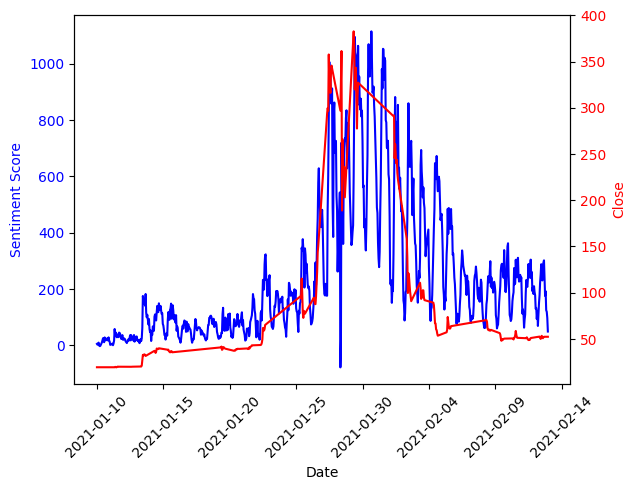

In [22]:
from matplotlib.dates import DateFormatter, DayLocator
## df[['fourier 5', 'fourier 10', 'fourier 15', 'fourier 20']]
fig, ax1 = plt.subplots()
ax1.plot(gme.index, gme['Sentiment_Score'], color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(gme.index, gme['close'], color='red')
ax2.set_ylabel('Close', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# set the x-tick frequency to every 5 days
ax1.xaxis.set_major_locator(DayLocator(interval=5))
# format the x-tick labels as 'YYYY-MM-DD'
date_formatter = DateFormatter('%Y-%m-%d')
ax1.xaxis.set_major_formatter(date_formatter)
# rotate the x-tick labels by 45 degrees
ax1.tick_params(axis='x', labelrotation=45)

plt.show()

# Correlation

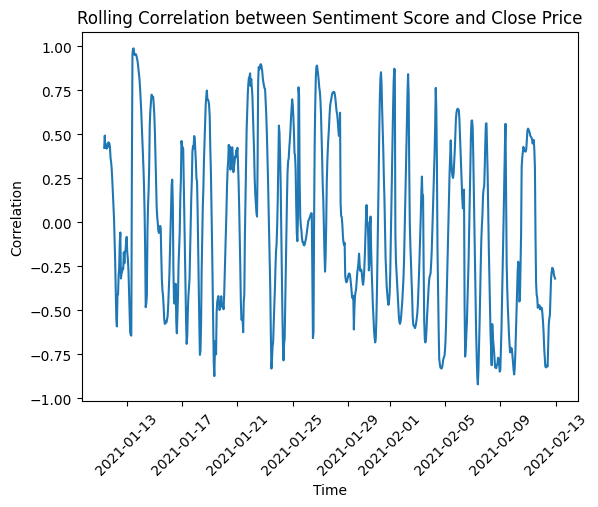

In [23]:
rolling_corr = gme['Updated_Sentiment_Score'].rolling(window=24).corr(gme['close'])
plt.plot(rolling_corr)
plt.title('Rolling Correlation between Sentiment Score and Close Price')
plt.xlabel('Time')
plt.ylabel('Correlation')
plt.xticks(rotation=45)

plt.show()

# Fourier transform

In [24]:
## fourier transform
close_fft = np.fft.fft(np.asarray(gme['Sentiment_Score'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
fft_list = np.asarray(fft_df['fft'].tolist())

for num_ in [5, 10, 15, 20]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    gme['fourier '+str(num_)]=np.fft.ifft(fft_list_m10)

# LSTM

In [25]:
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
from keras.models import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Bidirectional, LSTM, RepeatVector, Dense, TimeDistributed # for creating layers inside the Neural Network
from keras.layers import Dropout

# Data manipulation
import pandas as pd # for data manipulation
import numpy as np # for data manipulation

# Sklearn
import sklearn
from sklearn.preprocessing import MinMaxScaler # for feature scaling

# Visualization
import plotly 
import plotly.express as px
import plotly.graph_objects as go

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/opt/conda/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


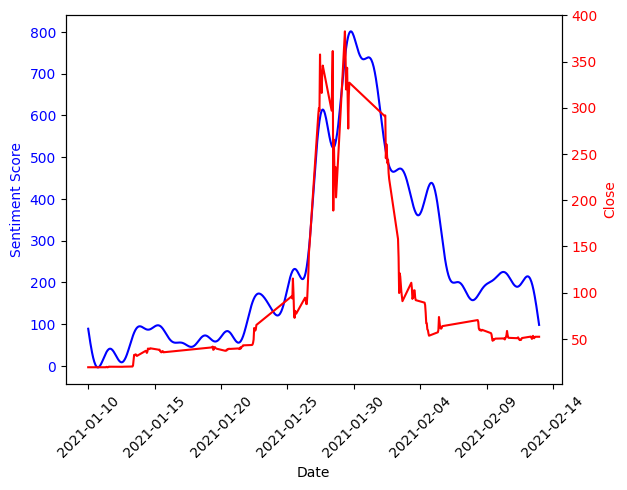

In [26]:
from matplotlib.dates import DateFormatter, DayLocator
## df[['fourier 5', 'fourier 10', 'fourier 15', 'fourier 20']]
fig, ax1 = plt.subplots()
ax1.plot(gme.index, gme['fourier 20'], color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(gme.index, gme['close'], color='red')
ax2.set_ylabel('Close', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# set the x-tick frequency to every 5 days
ax1.xaxis.set_major_locator(DayLocator(interval=5))
# format the x-tick labels as 'YYYY-MM-DD'
date_formatter = DateFormatter('%Y-%m-%d')
ax1.xaxis.set_major_formatter(date_formatter)
# rotate the x-tick labels by 45 degrees
ax1.tick_params(axis='x', labelrotation=45)

plt.show()

In [27]:
def create_lstm_data(gme, train_timestep, pred_timestep, size = 0.8):
    # split data into train and test sets
    train_size = int(len(gme)*size)
    train_gme = gme[:train_size]
    test_gme = gme[train_size:]
    
    # create train data
    X_train, Y_train = [], []
    for i in range(train_timestep, len(train_gme)-pred_timestep):
        X_train.append(np.array(train_gme.iloc[i - train_timestep:i]))
        Y_train.append(np.array(train_gme.iloc[i:i+pred_timestep]['close']))
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # create test data
    X_test, Y_test = [], []
    for i in range(train_timestep, len(test_gme)-pred_timestep):
        X_test.append(np.array(test_gme.iloc[i - train_timestep:i]))
        Y_test.append(np.array(test_gme.iloc[i:i+pred_timestep]['close']))
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    return X_train, Y_train, X_test, Y_test

In [29]:
temp = gme[['Updated_Sentiment_Score','close']]
##### Step 1 - Specify parameters
window_size = 48
pred_size = 1

##### Step 2 - Prepare data

# Split the DataFrame into train and test sets
X_train, y_train, X_test, y_test = create_lstm_data(temp, train_timestep=window_size, pred_timestep=pred_size)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

##### Step 3 - Specify the structure of a Neural Network
# Define LSTM model architecture
model = Sequential()
model.add(LSTM(units=256, return_sequences = True, input_shape=(window_size, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 96, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 48))
model.add(Dropout(0.2))
model.add(Dense(units=1))

##### Step 4 - Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

##### Step 5 - Fit the model on the dataset
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


##### Step 6 - Use model to make predictions
# Predict results on training data
pred_train = model.predict(X_train)
# Predict results on test data
pred_test = model.predict(X_test)


##### Step 7 - Print Performance Summary
print("")
print('-------------------- Model Summary --------------------')
model.summary() # print model summary
print("")
print('-------------------- Weights and Biases --------------------')
print("Too many parameters to print but you can use the code provided if needed")
print("")
#for layer in model.layers:
#    print(layer.name)
#    for item in layer.get_weights():
#        print("  ", item)
#print("")

history = model.history

# Print the last value in the evaluation metrics contained within history file
print('-------------------- Evaluation on Training Data --------------------')
for item in history.history:
    print("Final", item, ":", history.history[item][-1])
print("")

# Evaluate the model on the test data using "evaluate"
print('-------------------- Evaluation on Test Data --------------------')
results = model.evaluate(X_test, y_test)
print("")

X_train shape: (603, 48, 2)
y_train shape: (603, 1)
X_test shape: (115, 48, 2)
y_test shape: (115, 1)
Epoch 1/30
19/19 [==============================] - 9s 110ms/step - loss: 24036.4727 - val_loss: 2142.1709
Epoch 2/30
19/19 [==============================] - 0s 26ms/step - loss: 22995.7949 - val_loss: 1926.2335
Epoch 3/30
19/19 [==============================] - 0s 24ms/step - loss: 22639.3574 - val_loss: 1824.9668
Epoch 4/30
19/19 [==============================] - 0s 22ms/step - loss: 22428.3418 - val_loss: 1740.0446
Epoch 5/30
19/19 [==============================] - 0s 22ms/step - loss: 22224.3223 - val_loss: 1659.1461
Epoch 6/30
19/19 [==============================] - 0s 22ms/step - loss: 21983.7305 - val_loss: 1584.5046
Epoch 7/30
19/19 [==============================] - 0s 24ms/step - loss: 21802.7598 - val_loss: 1510.9998
Epoch 8/30
19/19 [==============================] - 0s 22ms/step - loss: 21637.3105 - val_loss: 1441.9336
Epoch 9/30
19/19 [==============================]

4/4 [==============================] - 0s 7ms/step


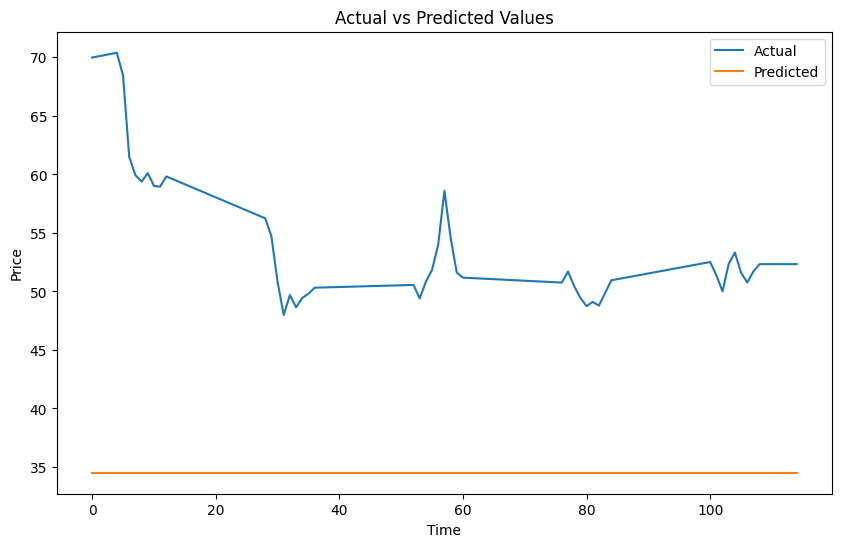

In [30]:
y_pred = model.predict(X_test)

# Plot predicted and actual values
plt.figure(figsize=(10,6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()